In [3]:
using DrWatson
@quickactivate "Doran_etal_2022"

using MLJ, SPI
using Distances
using StatsPlots, StatsBase
using Muon, CSV, DataFrames

include(srcdir("helpers.jl"));

In [4]:
ddir = datadir("exp_pro", "BB728") |> mkpath
rdir = projectdir("_research", "CSB_consortia") |> mkpath
pdir = plotsdir("CSB_consortia") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB728.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/ben/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 728 ✕ 21485
└ metabolites_foldchange
  AnnData object 728 ✕ 50
└ metabolites_millimolar
  AnnData object 728 ✕ 10
└ UPorder_oggs
  AnnData object 728 ✕ 10177
└ oggs
  AnnData object 728 ✕ 11248

Rita's consortia

* MSK.1.10
* MSK.19.28
* MSK.20.34
* MSK.7.21
* MSK.7.7

taxa?

* MSK1_10 Collinsella_aerofaciens
* MSK19_28 unclassified
* MSK20_34 Bacteroides_xylanisolvens
* MSK7_21 TM396_Clostridium_symbosium
* MSK7_7 TM388_Clostridium_innocuum

In [118]:
ritas5 = [
    "MSK.1.10",
    "MSK.19.28",
    "MSK.20.34",
    "MSK.7.21",
    "MSK.7.7",
]
indexin(ritas5, biobank["UPorder_oggs"].obs_names)

5-element Vector{Union{Nothing, Int64}}:
    nothing
    nothing
    nothing
 189
 188

## Add Missing isolates

In [2]:
missing3df = CSV.read(joinpath(ddir, "missing3.ogg.csv"), DataFrame; header=1);
missing3df[:, :val] .= 1.;

UndefVarError: UndefVarError: ddir not defined

In [27]:
m3df_wide = missing3df |> 
    df -> select(df, [:seq_id, :COG, :val]) |>
    df -> DataFrames.transform(df, :COG => (x->replace.(x, "@2"=>"")) => :COG) |>
    df -> unstack(df, :COG, :val; combine=sum, fill=0.0) |>
    df -> DataFrames.transform(df, :seq_id => (x->replace.(x, "MSK"=>"MSK.", "_"=>".")) => :seq_id)

Row,seq_id,COG1143,COG2304,COG4932,COG0199,32TA9,COG0718,COG0456,COG1476,COG3077,COG1186,COG1716,COG0096,COG1329,32988,COG0669,COG3947,COG0543,COG1595,31U4I,COG3944,COG2222,COG0561,COG0771,COG3442,COG3655,COG1173,COG3547,COG0622,COG1454,COG3968,COG0685,COG1410,COG0646,COG2217,COG2848,COG2265,COG1534,COG2909,COG3629,COG0363,COG2190,COG2087,COG1109,COG0103,COG0102,COG4667,COG1848,COG1132,COG2207,COG1373,COG0064,COG0154,COG0721,COG3764,COG3210,COG2814,COG0315,COG1763,COG2896,COG2852,COG0265,COG0534,COG0789,COG0272,COG0745,COG0174,COG2361,COG1669,COG1609,COG0524,COG0800,COG2801,COG1802,COG0537,COG2364,COG0489,COG1672,COG2865,COG0129,COG2610,COG2186,COG1028,COG0698,COG0446,COG1902,COG2233,COG2156,COG2216,COG1082,COG2060,COG2205,COG0493,COG4225,COG2755,COG0412,COG0657,COG5434,COG0781,COG2211,⋯
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,MSK.1.10,6.0,1.0,4.0,1.0,1.0,1.0,3.0,7.0,7.0,2.0,6.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,10.0,12.0,2.0,1.0,4.0,2.0,3.0,2.0,4.0,1.0,1.0,2.0,2.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,2.0,4.0,1.0,1.0,2.0,3.0,14.0,3.0,7.0,1.0,1.0,1.0,1.0,2.0,7.0,1.0,1.0,1.0,8.0,1.0,4.0,5.0,1.0,10.0,1.0,1.0,3.0,11.0,4.0,1.0,4.0,2.0,2.0,1.0,2.0,6.0,5.0,1.0,1.0,1.0,7.0,4.0,3.0,3.0,2.0,1.0,1.0,4.0,1.0,6.0,7.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0,⋯
2,MSK.20.34,7.0,6.0,0.0,1.0,0.0,0.0,13.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,3.0,2.0,57.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,48.0,13.0,0.0,0.0,0.0,0.0,2.0,9.0,0.0,0.0,0.0,1.0,2.0,14.0,5.0,1.0,51.0,1.0,3.0,4.0,6.0,7.0,1.0,3.0,0.0,2.0,1.0,4.0,19.0,5.0,1.0,1.0,1.0,8.0,1.0,3.0,1.0,2.0,1.0,1.0,7.0,1.0,49.0,2.0,19.0,20.0,1.0,3.0,15.0,1.0,3.0,⋯
3,MSK.19.28,4.0,1.0,1.0,1.0,0.0,1.0,9.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,2.0,6.0,1.0,0.0,0.0,5.0,4.0,1.0,5.0,0.0,1.0,1.0,1.0,3.0,0.0,3.0,1.0,2.0,0.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,0.0,5.0,18.0,0.0,0.0,0.0,0.0,0.0,3.0,33.0,1.0,1.0,1.0,1.0,4.0,3.0,6.0,4.0,21.0,2.0,1.0,1.0,15.0,11.0,2.0,14.0,4.0,1.0,0.0,3.0,0.0,0.0,2.0,4.0,9.0,18.0,1.0,4.0,2.0,6.0,1.0,1.0,3.0,1.0,13.0,5.0,0.0,1.0,2.0,1.0,0.0,2.0,6.0,⋯


In [117]:
mappedM3 = match_column_order(
    Matrix(m3df_wide[:, 2:end]), 
    names(m3df_wide)[2:end], 
    biobank["UPorder_oggs"].var.ID
);
UPusv = SVD(biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:], biobank["UPorder_oggs"].uns["UP_SVs"][:], biobank["UPorder_oggs"].varm["UP_RSVs"][:,:]');
UPinf = biobank["UPorder_oggs"]
M3obs = coalesce.(vcat(biobank.obs, DataFrame(:ID => m3df_wide.seq_id, :donor=> ["1", "19", "20"], :inBB673=>[0,0,0]), cols=:union), "");

In [109]:
m3adata = AnnData(X=vcat(UPinf.X[:,:], mappedM3), 
    obs_names = vcat(UPinf.obs_names.vals, m3df_wide.seq_id), 
    var_names = UPinf.var_names.vals,
    var = UPinf.var[:, :],
    obs = M3obs,
    uns = Dict("UP_SVs" => UPinf.uns["UP_SVs"]),
    varm = Dict("UP_RSVs" => UPinf.varm["UP_RSVs"]),
    obsm = Dict("inferredLSVs" => vcat(UPinf.obsm["inferredLSVs"][:, :], projectinLSV(mappedM3, UPusv))),
)

AnnData object 731 ✕ 10177

In [115]:
m3adata.obsp["SDij"] = calc_spi_mtx(m3adata.obsm["inferredLSVs"][:, :], m3adata.uns["UP_SVs"], getintervals(m3adata.uns["UP_SVs"])) ./ size(m3adata, 2);

In [116]:
Muon.writeh5ad(joinpath(rdir, "allcsb.h5ad"), m3adata);

## Get neighbors

In [5]:
m3ad = Muon.readh5ad(joinpath(rdir, "allcsb.h5ad"));

In [6]:
ritas5 = [
    "MSK.1.10",
    "MSK.19.28",
    "MSK.20.34",
    "MSK.7.21",
    "MSK.7.7",
]

5-element Vector{String}:
 "MSK.1.10"
 "MSK.19.28"
 "MSK.20.34"
 "MSK.7.21"
 "MSK.7.7"

In [7]:
queries = indexin(ritas5, m3ad.obs_names)

5-element Vector{Union{Nothing, Int64}}:
 729
 731
 730
 189
 188

In [8]:
dists = m3ad.obsp["SDij"][queries, Not(queries)]

5×726 Matrix{Float64}:
 2.74907  3.71581  3.44548  3.35761  …  2.7      4.20977  2.63908  4.23644
 3.60464  4.46652  4.14948  4.06169     3.91053  4.74403  3.84771  5.25938
 3.72346  4.74186  4.36733  3.58777     5.15173  6.39699  5.11195  6.56629
 5.07974  5.78588  5.61118  5.57918     5.27461  5.4363   5.2217   6.03681
 6.94701  7.708    7.5157   7.30477     6.88334  7.99267  6.77663  7.8244

In [30]:
palette(:default)[1:5]'

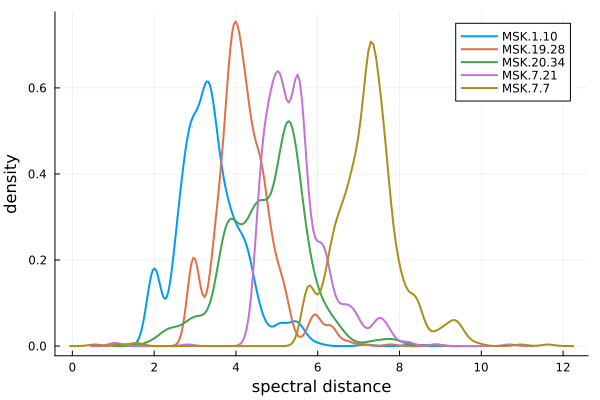

In [36]:
density(dists', labels=permutedims(ritas5),
    ylabel="density",
    xlabel="spectral distance",
    lw=2,
)
# vline!(mapslices(minimum, dists, dims=2)[1:1]', c=palette(:default)[1:5]', lw=2, ls=:dash)

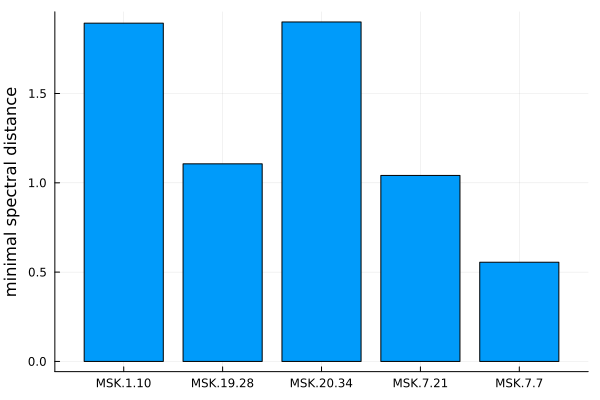

In [43]:
bar(mapslices(minimum, dists, dims=2),
    ylabel="minimal spectral distance",
    xticks=(1:5, ritas5),
    label="",
    )

In [44]:
queryidxs = mapslices(x->partialsortperm(x, 1:5), dists, dims=2)

5×5 Matrix{Int64}:
 495  521  529  507  512
 717  529  512  507  487
 412  420   15  407  417
 241  240  259  479  487
 170  243  187  185  699

In [45]:
nnsIDs = mapslices(x-> begin
    [join(x, " ") for x in eachrow(m3ad.obs[x, [:ID, :species]])]
end, queryidxs, dims=2)

5×5 Matrix{String}:
 "MSK.2.21 Pediococcus acidilactici"    …  "MSK.22.109 Bifidobacterium breve"
 "DFI.1.180 Dorea formicigenerans"         "MSK.2.7 Pediococcus acidilactici"
 "MSK.16.18 Bacteroides xylanisolvens"     "MSK.16.41 Bacteroides xylanisolvens"
 "MSK.18.54 [Ruminococcus] lactaris"       "MSK.2.7 Pediococcus acidilactici"
 "MSK.13.34 [Clostridium] innocuum"        "MSK.16.15 Bacteroides eggerthii"

In [47]:
NNsdf = DataFrame(hcat(ritas5, nnsIDs),
    ["Block20", "NN1", "NN2", "NN3", "NN4", "NN5"])

Row,Block20,NN1,NN2,NN3,NN4,NN5
,String,String,String,String,String,String
1,MSK.1.10,MSK.2.21 Pediococcus acidilactici,MSK.22.65 Bifidobacterium breve,MSK.22.64 Bifidobacterium breve,DFI.1.40 Streptococcus salivarius,MSK.22.109 Bifidobacterium breve
2,MSK.19.28,DFI.1.180 Dorea formicigenerans,MSK.22.64 Bifidobacterium breve,MSK.22.109 Bifidobacterium breve,DFI.1.40 Streptococcus salivarius,MSK.2.7 Pediococcus acidilactici
3,MSK.20.34,MSK.16.18 Bacteroides xylanisolvens,MSK.16.78 Bacteroides xylanisolvens,MSK.17.76 Bacteroides ovatus,MSK.16.82 Bacteroides xylanisolvens,MSK.16.41 Bacteroides xylanisolvens
4,MSK.7.21,MSK.18.54 [Ruminococcus] lactaris,MSK.17.22 [Ruminococcus] lactaris,MSK.14.20 Faecalicatena fissicatena,MSK.2.77 Pediococcus acidilactici,MSK.2.7 Pediococcus acidilactici
5,MSK.7.7,MSK.13.34 [Clostridium] innocuum,MSK.1.7 [Clostridium] symbiosum,MSK.6.1 [Clostridium] innocuum,MSK.5.23 [Clostridium] innocuum,MSK.16.15 Bacteroides eggerthii


In [48]:
CSV.write(joinpath(rdir, "NNsResults.csv"), NNsdf)

"/Users/ben/projects/Doran_etal_2022/_research/CSB_consortia/NNsResults.csv"

In [173]:
hc = hclust(m3ad.obsp["SDij"], linkage=:average, branchorder=:optimal)

Clustering.Hclust{Float64}([-538 -683; 1 -686; … ; 728 726; 729 -546], [1.4147610273648306e-17, 1.4147610273648306e-17, 1.4147610273648306e-17, 1.4147610273648306e-17, 1.7845954881849597e-17, 0.00017380078633542635, 0.00046478366946509385, 3.2392254207710726e-17, 3.2392254207710726e-17, 3.2392254207710726e-17  …  5.50933240322319, 5.550142624284058, 5.605013369037968, 0.9071445013023584, 1.3228005992345069, 6.172366087158303, 0.5552273534848263, 1.4650582926161877, 6.627606247541306, 7.552622263341825], [188, 170, 185, 187, 245, 116, 114, 261, 242, 243  …  16, 411, 681, 678, 679, 676, 673, 674, 675, 546], :average)

In [174]:
csbnwstr = nwstr(hc, m3ad.obs_names.vals; labelinternalnodes=false)

"((((MSK.7.7:5.552274e-01,MSK.13.34:5.552274e-01):9.098309e-01,(MSK.5.23:1.322801e+00,(MSK.6.1:9.071445e-01,MSK.15.85:9.071445e-01):4.156561e-01):1.422577e-01):5.162548e+00,(UOC.14.97:6.172366e+00,((MSK.20.9:5.550143e+00,((DFI.5.64:2.379665e+00,((MSK.1.9:9.612194e-04,MSK" ⋯ 26960 bytes ⋯ "4.398098e-04,MSK.18.14:4.398098e-04):8.376228e-04,MSK.18.17:1.277433e-03):1.276894e-03):1.754158e-02,(MSK.18.57:1.965046e-03,MSK.18.52:1.965046e-03):1.813086e-02):1.913447e+00):3.671470e+00):5.673527e-01):4.552402e-01):9.250160e-01,MSK.20.82:7.552622e+00):0.000000e+00;"

In [175]:
open(joinpath(rdir, "csbtree.nw"), "w") do io
    println(io, csbnwstr);
end

In [64]:
m3ad.obs[:, :label] .= map(x-> join(x, " "), zip(m3ad.obs.ID, m3ad.obs.species))

731-element Vector{String}:
 "MSK.16.19 Bacteroides eggerthii"
 "MSK.10.5 Bacteroides fragilis"
 "MSK.13.23 Bacteroides fragilis"
 "MSK.16.61 Phocaeicola vulgatus"
 "MSK.18.56 Bacteroides caccae"
 "MSK.18.69 Bacteroides caccae"
 "MSK.14.51 Bacteroides thetaiotaomicron"
 "MSK.9.20 Phocaeicola vulgatus"
 "MSK.16.76 Bacteroides xylanisolvens"
 "MSK.15.13 Phocaeicola vulgatus"
 ⋮
 "DFI.4.9 Blautia wexlerae"
 "DFI.1.105 Lachnospiraceae sp."
 "DFI.3.107 Lachnospiraceae sp."
 "DFI.1.162 [Clostridium] scindens"
 "DFI.3.120 unclassified"
 "DFI.1.51 Faecalimonas umbilicata"
 "MSK.1.10 "
 "MSK.20.34 "
 "MSK.19.28 "

In [172]:
CSV.write(joinpath(rdir, "csbtree_obs.csv"), m3ad.obs[:, [:ID, :label, :phylum, :class, :order, :family, :genus, :species]])

"/Users/ben/projects/Doran_etal_2022/_research/CSB_consortia/csbtree_obs.csv"

In [52]:
using UMAP

In [55]:
SDij = m3ad.obsp["SDij"][:, :];

In [80]:
embedding = umap(SDij, 2; metric=:precomputed, n_neighbors=730, n_epochs=800)'

731×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -19.477   -1.51919
 -20.6228  -1.41212
 -20.71    -1.48063
 -22.9032  -0.0683373
 -21.1865  -0.319599
 -21.1238  -0.32689
 -17.5331   1.53932
 -23.502    0.518167
 -18.5803   1.54477
 -23.7259   0.708378
   ⋮       
 -21.3252  -6.13399
 -22.8214  -4.74264
 -22.8641  -4.65496
 -21.9469  -2.96141
 -23.0442  -4.65987
 -22.323   -3.84543
 -20.7147  -3.35405
 -18.3009   1.39592
 -20.409   -3.41663

In [61]:
plotlyjs()

Plots.PlotlyJSBackend()

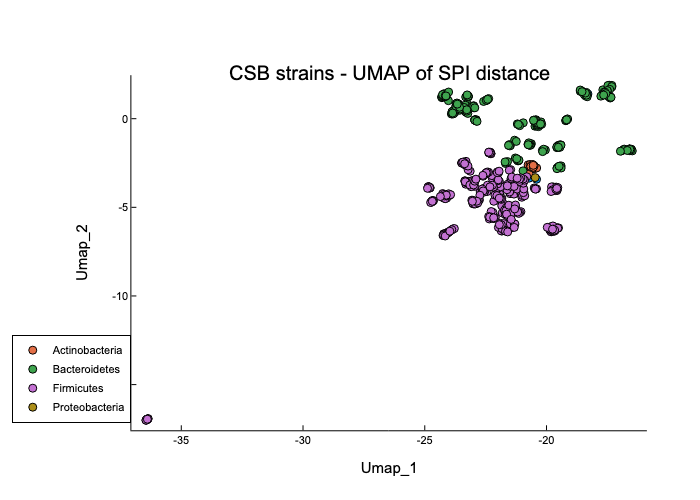

In [83]:
scatter(
    embedding[:, 1], embedding[:, 2],
    group=m3ad.obs.phylum,
    hover=m3ad.obs.label,
    legend=:outerbottomleft,
    size=(700, 600),
    grid=false,
    title="CSB strains - UMAP of SPI distance",
    xlabel="Umap_1",
    ylabel="Umap_2",
    )